In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [87]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [15]:
class Config():
    training_dir = "/content/drive/MyDrive/siamese_data/sounds/2D+fourier/training/"
    testing_dir = "/content/drive/MyDrive/siamese_data/sounds/2D+fourier/testing/"
    train_batch_size = 64
    train_number_epochs = 100

In [89]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
print(folder_dataset)

Dataset ImageFolder
    Number of datapoints: 14
    Root location: /content/drive/MyDrive/siamese_data/sounds/2D+fourier/training/


In [90]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

In [92]:
net = SiameseNetwork().cuda()
net.load_state_dict(torch.load('/content/drive/MyDrive/siamese_data/sounds/models/test.pt'))
net.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

In [166]:
def preprocessing(img_path):
  preprocess = transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
  img = Image.open(img_path)
  img = img.convert("L")
  img = preprocess(img)
  return img.view([1,1,100,100])

In [173]:
new_data = preprocessing('/content/drive/MyDrive/siamese_data/sounds/2D+fourier/testing/sample_test/2.png')

In [175]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    # print(npimg.shape)
    shape = np.transpose(npimg, (1, 2, 0))
    plt.imshow(shape)
    # print(shape.shape)
    plt.show()

## show GUI

sample
0.8108093738555908


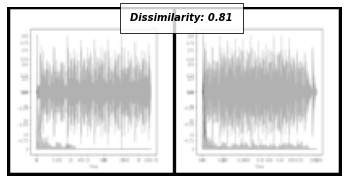

sample
0.7856515645980835


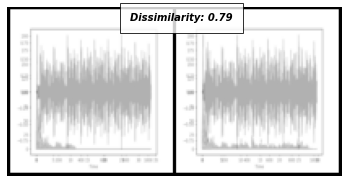

반갑습니다
3.092421531677246


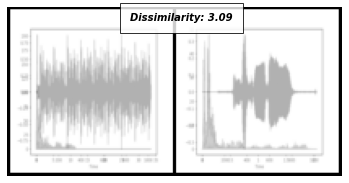

반갑습니다
2.9830851554870605


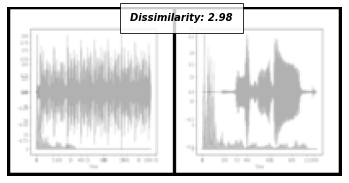

반갑습니다
3.049131155014038


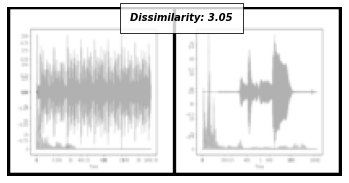

반갑습니다
2.848003387451172


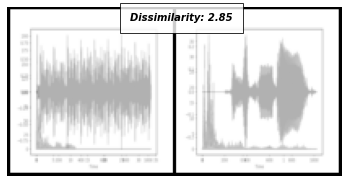

새해복 많이 받으세요
1.9778079986572266


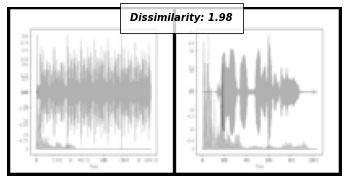

새해복 많이 받으세요
2.056455135345459


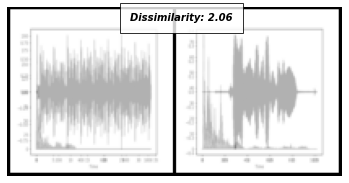

새해복 많이 받으세요
1.9535934925079346


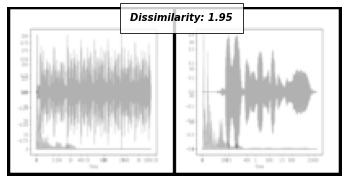

새해복 많이 받으세요
1.9660173654556274


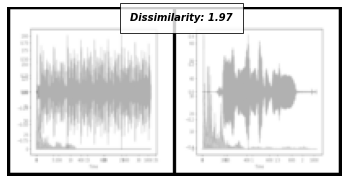

저는 최재혁입니다
1.7920504808425903


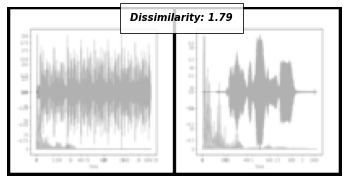

저는 최재혁입니다
1.8954766988754272


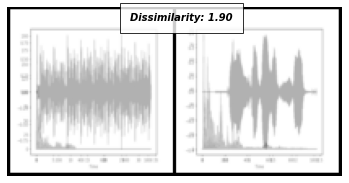

저는 최재혁입니다
1.9089053869247437


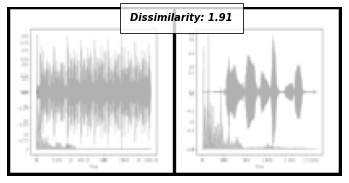

저는 최재혁입니다
1.8546795845031738


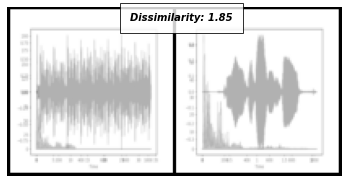

In [176]:
test_dataloader = DataLoader(siamese_dataset, num_workers=6, batch_size=1, shuffle=False)

for i in range(len(test_dataloader)):
  print(test_dataloader.dataset.imageFolderDataset.imgs[i][0].split('/')[-2])
  data = preprocessing(test_dataloader.dataset.imageFolderDataset.imgs[i][0])
  concatenated = torch.cat((new_data, data),0)

  output1,output2 = net(Variable(new_data).cuda(),Variable(data).cuda())
  euclidean_distance = F.pairwise_distance(output1, output2)
  print(euclidean_distance.item())
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

## show correct label

In [178]:
for i in range(len(test_dataloader)):
  data_label = test_dataloader.dataset.imageFolderDataset.imgs[i][0].split('/')[-2]
  data = preprocessing(test_dataloader.dataset.imageFolderDataset.imgs[i][0])
  concatenated = torch.cat((new_data, data),0)

  output1,output2 = net(Variable(new_data).cuda(),Variable(data).cuda())
  euclidean_distance = F.pairwise_distance(output1, output2)
  
  if euclidean_distance.item() < 1.0:
    print(data_label)

sample
sample
